# Database Examples
Examples of different ways to use the database or to store additional information and plot it.  
All the examples are based on the **Integrated_variable_input** example of the *Synapses* notebook.
- Save standard attributes: num_children, firing_rate or weight: [Save_attributes](#Save_attributes)
- Save user defined extra attributes in the database: [Save_extra_attributes](#Save_extra_attributes)
- Plot the extra attributes: [Plot_attributes](#Plot_attributes)

## Save_attributes
Demonstrates how to save standard ``Front``, ``Neuron`` or ``Synapse`` attributes that are normally not saved or updated in the database.  

First a ``Front`` attribute: *num_children* is not stored because it can be inferred from the parent-child relationships that are stored. But for debugging it may be useful to store *num_children*.  

The only change to the code is the addition of ``admin.attrib_to_db`` on line 221 of the code. In addition to the attribute (``"num_children"``) its database type (``"int"``) needs to be specified. The ``last_only`` option is set to True so that only the final value of *num_children* is stored.

In [1]:
from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extra attribute integrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 100:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)                

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 100:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/store_num_children_end.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0)

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"integrate_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
    
    # save num_children attribute at the end of the simulation
    admin.attrib_to_db(SimpleNeuronFront,"num_children","int",last_only=True)

    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction(exit=False)
    
    print ("store_num_children_end.db created")

store_num_children_end.db created


To know whether anything was stored the database needs to be queried. The *processing* library contains several methods that can do so.

First, the ``DataID`` of the fronts for which data was stored needs to be known. This can be obtained with the *processing* ``nds_list_data`` method that will also list the attribute value (or the range of values if several entries are stored). Because the number of fronts is very large we request only the first 10 stored:

In [2]:
from neurodevsim.processing import *

nds_list_data("output/store_num_children_end.db","num_children",num_data=10)

output/store_num_children_end.db num_children_data contains data for 616 fronts or neurons:
Front data id: neuron_id 1, front_id 1 : 1 data point for cycle 90 value 8
Front data id: neuron_id 1, front_id 4001 : 1 data point for cycle 90 value 1
Front data id: neuron_id 1, front_id 4002 : 1 data point for cycle 90 value 2
Front data id: neuron_id 1, front_id 4003 : 1 data point for cycle 90 value 1
Front data id: neuron_id 1, front_id 4004 : 1 data point for cycle 90 value 1
Front data id: neuron_id 1, front_id 4005 : 1 data point for cycle 90 value 1
Front data id: neuron_id 1, front_id 4006 : 1 data point for cycle 90 value 1
Front data id: neuron_id 1, front_id 4007 : 1 data point for cycle 90 value 1
Front data id: neuron_id 1, front_id 4008 : 1 data point for cycle 90 value 1
Front data id: neuron_id 1, front_id 4009 : 1 data point for cycle 90 value 1


The results are as expected: the first value listed is for the soma which has 8 dendrites. Rest of the fronts have usually only one child, sometimes 2 in case of branching or 0 in case of a terminal front (terminal fronts are created later and therefore usually not present in the list of 10 first).  

Only attributes that change or that are not already stored can be used in ``admin.attrib_to_db``, otherwise it generates an error as illustrated with the following code that tries to store ``Front`` *order*.

In [3]:
from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extra attribute integrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 100:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)                

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 100:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/store_order_end.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0)

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"integrate_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
    
    # try to save order attribute at the end of the simulation
    try:
        admin.attrib_to_db(SimpleNeuronFront,"order","int",last_only=True)
    except Exception as error:
        print (error)

    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction(exit=False)

Type error: Front attribute 'order' already stored in database.


For some attributes, like ``Neuron`` *firing_rate* or ``Synapse`` *weight*, only the initial value is stored by default. They can also be saved continuously by ``admin.attrib_to_db`` as ``"real"`` database types, but for these attributes the ``object``needs also to be specified (lines 220-223).

In [4]:
from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extra attribute integrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 100:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)                

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 100:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/store_rate_weight.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0)

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"integrate_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
    
    # save neuron firing_rate continuously for axons
    admin.attrib_to_db(AxonFront,"firing_rate","real",object=Neuron)
    # save synapse weight continuously for the simple neuron
    admin.attrib_to_db(SimpleNeuronFront,"weight","real",object=Synapse)

    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction(exit=False)
    
    print ("store_rate_weight.db created")

store_rate_weight.db created


Again, the database contents can be investigated with ``nds_list_data``:

In [5]:
nds_list_data("output/store_rate_weight.db","firing_rate")

output/store_rate_weight.db firing_rate_data contains data for 10 fronts or neurons:
Neuron data id: neuron_id 4 : 90 data points for cycles 1 - 90 , range 1.25 - 3.12
Neuron data id: neuron_id 2 : 90 data points for cycles 1 - 90 , range 2.00 - 5.19
Neuron data id: neuron_id 7 : 90 data points for cycles 1 - 90 , range 4.41 - 4.41
Neuron data id: neuron_id 3 : 90 data points for cycles 1 - 90 , range 1.82 - 9.34
Neuron data id: neuron_id 6 : 90 data points for cycles 1 - 90 , range 3.30 - 7.95
Neuron data id: neuron_id 8 : 90 data points for cycles 1 - 90 , range 7.25 - 8.45
Neuron data id: neuron_id 10 : 90 data points for cycles 1 - 90 , range 1.38 - 1.38
Neuron data id: neuron_id 9 : 90 data points for cycles 1 - 90 , range 9.29 - 9.29
Neuron data id: neuron_id 11 : 90 data points for cycles 1 - 90 , range 9.16 - 9.79
Neuron data id: neuron_id 5 : 90 data points for cycles 1 - 90 , range 3.13 - 9.06


Let's also get some data out of the database and print it. The Front ID was obtained from above.

In [6]:
data = nds_output_data("output/store_rate_weight.db",DataID(8,0),"firing_rate")
fr = 0.
for item in data:
    if item[1] != fr:
        print (item)
        fr = item[1]

(1, 8.447162870391816)
(9, 7.246297746148311)


``nds_output_data`` returned a list of 90 (*cycle*, *firing_rate*) items. To reduce the output the routine above only prints cycles at which *firing_rate* changed.  

Instead the data can also be plotted, this is illustrated in [Plot_attributes](#Plot_attributes).

## Save_extra_attributes
Storing user defined extra attributes uses ``admin.attrib_to_db`` in a similar manner. The additional attribute *signal* is stored for all fronts of *integrate_neuron* on line 222.  
In this example continuous storage is used, but ``last_only=True`` would again only store at the last cycle which is more efficient if the attribute is only stored to prepare for ``import_simulation``.

In [7]:
from neurodevsim.simulator import *
import numpy as np

# Control parameters
MAX_FR = 10. # maximum firing_rate, firing_rate will be in range 0. - MAX_FR
NEW_FR = 0.01 # probability that firing_rate will change on this cycle
SIGNAL_DECAY = 20. # rate in cycles at which signal decays back to zero.

# The postsynaptic neuron
class SimpleNeuronFront(SynFront):
    # extra attribute integrates syn_input over time
    _fields_ = SynFront._fields_ + [('signal', c_double)]
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 8 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 8: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 8 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        elif self.num_children == 0: # grow if no children present
            if self.path_length >= 300:
                if self.is_postsynaptic(): # do not disable
                    self.clear_growing() # but stop growing
                else:
                    self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.30 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.03
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 100:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        if self.is_postsynaptic(): # do not disable
                            self.clear_growing() # but stop growing
                        else: # make front inactive: stops growing
                            self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    if self.is_postsynaptic(): # do not disable
                        self.clear_growing() # but stop growing
                    else: # make front inactive: stops growing
                        self.disable(constellation)
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            if self.is_postsynaptic(): # do not disable
                                self.clear_growing() # but stop growing
                            else: # make front inactive: stops growing
                                self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)
        else: # front has a synapse and integrates syn_input each cycle
            self.signal += self.syn_input - (self.signal / SIGNAL_DECAY)                

# Axons growing from left to right and trying to make synapses
class AxonFront(SynFront):
    # extra attributes initalized to False and 0, updated in manage_front
    _fields_ = Front._fields_ + [('goalID', ID),('next_branch',c_short)]
    # status1 is used to flag fronts on the main branch of the axon

    # Main branch grows towards left, side branches grow towards a synapse site
    def manage_front(self,constellation):
        if constellation.cycle == 1: # first axon, main not initialized
            self.set_status1() # mark as main branch
            # set initial firing rate
            neuron = self.get_neuron(constellation)
            rate = np.random.random() * MAX_FR
            neuron.set_firing_rate(constellation,rate)
        elif self.num_children > 0: # root of axon that remains active
            if np.random.random() < NEW_FR: # change firing rate
                neuron = self.get_neuron(constellation)
                rate = np.random.random() * MAX_FR
                neuron.set_firing_rate(constellation,rate)                
            return # do not grow anymore...
        if self.is_status1(): # continuation of main branch growing leftward
            count = 0 # counts number of add_child trials
            new_front = None
            while count < 10:
                # random component along current heading
                extension = Point(6.,0.,0.) + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos) # make a new front
                    new_front.set_status1() # mark as main branch
                    new_front.next_branch = max(0, self.next_branch - 1)
                    break # made a front
                except (CollisionError, GridCompetitionError, InsideParentError) as error:
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error
                except (VolumeError):
                    # growing outside of volume -> stop
                    self.disable(constellation)
                    return # completed this call
            if not new_front: # add_child failed
                self.disable(constellation)
                return # completed this call
            # check for nearby fronts: 
            targets = self.get_fronts(constellation,what='name',name="integrate_neuron",max_distance=50.)
            no_branch = True
            for t in targets: # list of (front,distance), ordered by increasing distance
                goal = t[0]
                if goal.swc_type == 1: # do not synapse on soma
                    continue
                # check whether target front already has a synapse
                if goal.has_synapse():
                    continue
                distance = t[1]
                if distance < 1.: # close enough for a new synapse without branching
                    #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid,goal._yid)
                    try:
                        self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                        self.disable(constellation) # no further growth of main
                        goal.enable(constellation) # make postsynaptic front active again so that it computes signal
                        return # done, no branching
                    except (SynapseError) as error:
                        print (error)
                elif self.next_branch == 0: # make a branch
                    self.goalID = goal.get_id()
                    new_front.next_branch = 5
                    rad = self.taper(0.7)
                    no_branch = False
                    break
            if no_branch:
                if self.order > 0: # terminate growth of this axon (main) branch 
                    self.disable(constellation)
                return # done, no branching
        else: # continuation of a branch
            goal = constellation.front_by_id(self.goalID)
            if goal.has_synapse(): # goal has been taken by other branch
                # start retraction of the branch, front by front
                parent = self.get_parent(constellation)
                if not parent.is_status1(): # branch front 
                    parent.enable(constellation) # make active so that it retracts also
                self.retract(constellation)
                return
            rad = self.taper(0.95)
        # grow or continue a side branch (can be initiation of first side front from main)
        direction = goal.surface_point_to(self.end) - self.end
        n_direction = direction.norm()
        distance = direction.length()
        if distance < 1.: # close enough for a new synapse
            #print ("cycle",constellation.cycle,":",self.get_neuron_name(constellation),"makes a synapse on",goal._fid)
            try:
                self.add_synapse(constellation,goal,1.) # add synapse as presynaptic partner
                goal.enable(constellation) # make postsynaptic front active again so that it computes signal
            except (SynapseError) as error:
                print (error)
            if self.order > 0: # terminate growth of this axon (main) branch 
                self.disable(constellation)
            return # done, no branching
        else: # grow nearer towards front
            count = 0 # counts number of add_child trials
            while count < 100:
                if distance < 6.: # grow very close to surface of front
                    extension = n_direction * ((distance - 1.) * 0.9) + unit_sample_on_sphere()
                else: # grow front in direction of goal with some noise
                    extension = n_direction * 5. + unit_sample_on_sphere() * 2.0
                new_pos = self.end + extension # compute position of child end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                    new_front.goalID = self.goalID
                    # make front inactive: stops growing -> will not call this method again
                    if self.order > 0: # terminate growth of this axon (main) branch 
                        self.disable(constellation)
                    return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    count += 1
                    continue # pick another new_pos, no attempt to correct the error

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/store_signal.db"
    sim_volume = [[0., 0., 0.], [500., 500., 500.]]
    neuron_types = [SimpleNeuronFront,AxonFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,max_synapse=400,verbose=0)

    # make simple neuron
    admin.add_neurons(SimpleNeuronFront,"integrate_neuron",1,[[300.0,250.0,250.0],[300.,250.,250.]],30.)

    # make 10 axons: these grow 'from outside' into the volume
    admin.add_neurons(AxonFront,"axon",10,[[1,100,100],[1,400,400]],1.,axon=[5.0,0.,0.])
    
    # save signal attribute at the end of the simulation
    admin.attrib_to_db(SimpleNeuronFront,"signal","real")

    # run the simulation
    admin.simulation_loop(90)

    # clean up
    admin.destruction(exit=False)
        
    print ("store_signal.db created")

store_signal.db created


## Plot_attributes
Demonstrates how to plot stored (extra) attributes. This vanilla version plots everything:

<IPython.core.display.Javascript object>


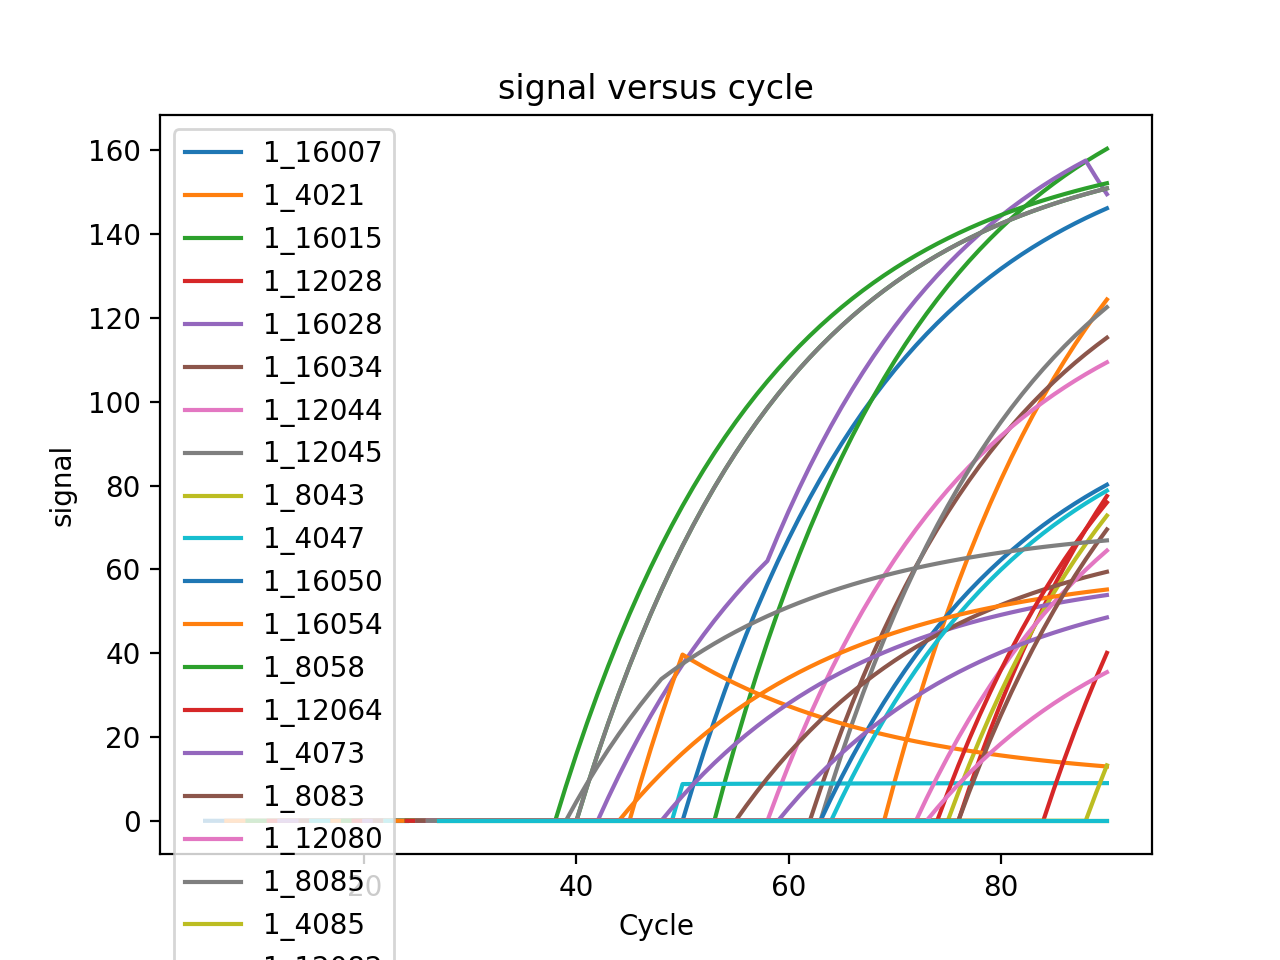

In [8]:
%matplotlib notebook
from neurodevsim.processing import *

nds_plot_data("output/store_signal.db","signal")

That was a very crowded plot and the legend is cut off.  
With the following optional parameters just the first 10 lines are plotted resulting in a more attractive plot.

<IPython.core.display.Javascript object>


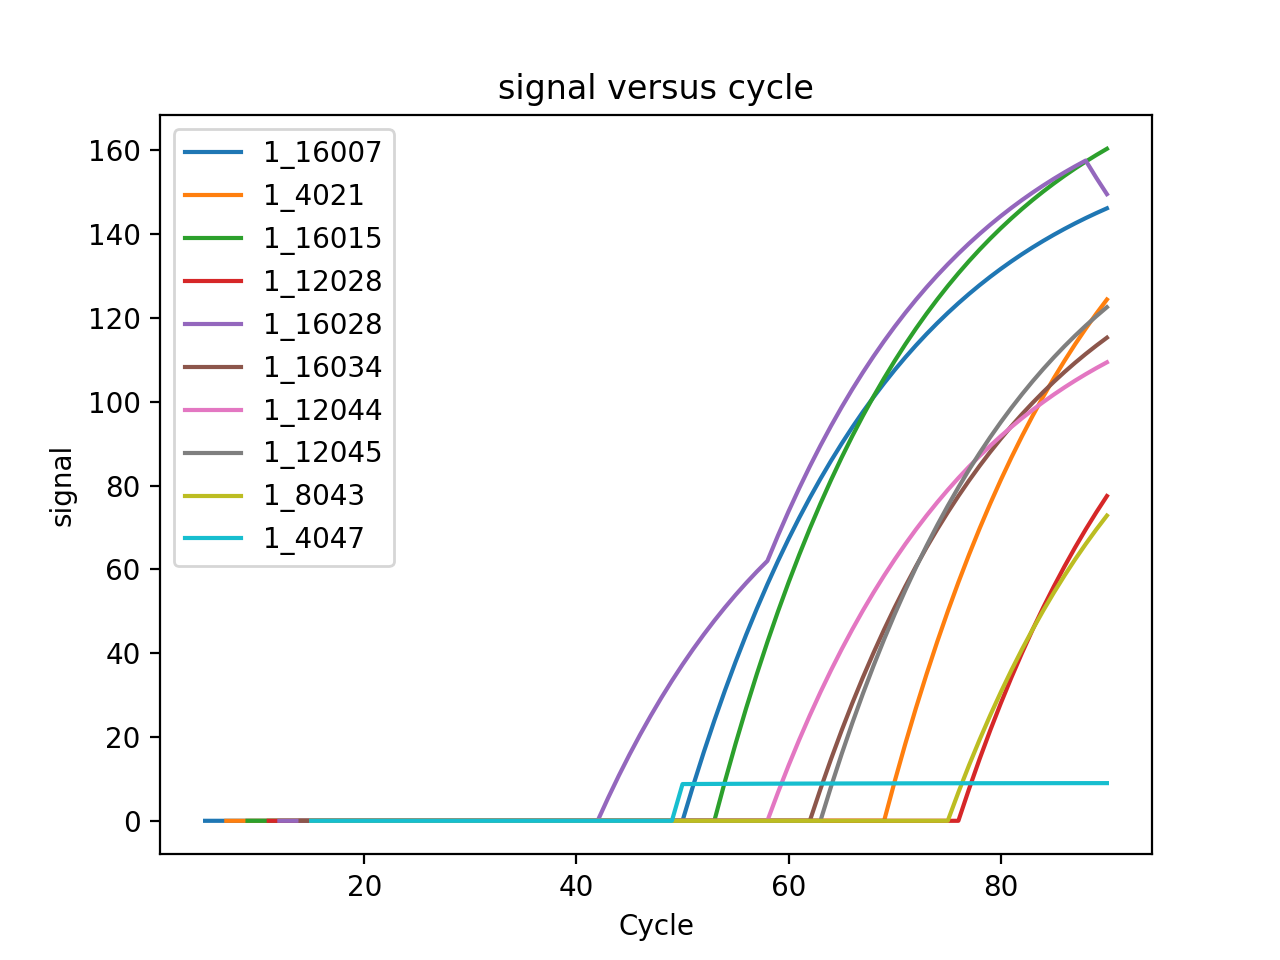

In [9]:
%matplotlib notebook

nds_plot_data("output/store_signal.db","signal",num_plots=10)

The plot above shows the first 10 in the database, to get the next 10 a range needs to be specified:

<IPython.core.display.Javascript object>


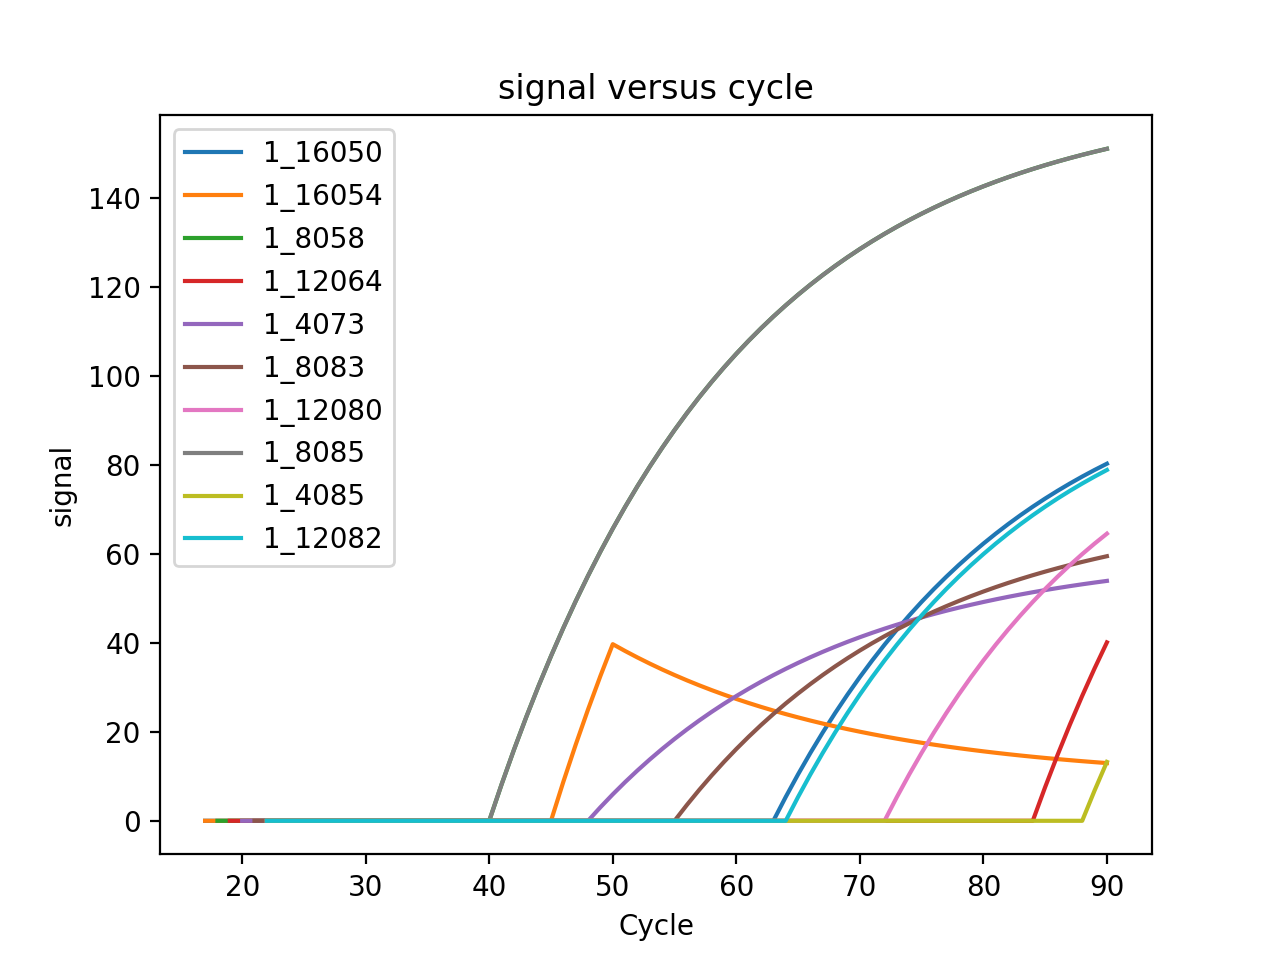

In [10]:
%matplotlib notebook

nds_plot_data("output/store_signal.db","signal",num_plots=[10,20])

The file "output/store_signal_cont.db" contains data for many fronts. This information and ids for the fronts can be obtained with the *nds_list_data* method:

In [11]:
nds_list_data("output/store_signal.db","signal")

output/store_signal.db signal_data contains data for 495 fronts or neurons:
Front data id: neuron_id 1, front_id 4001 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 4002 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 4003 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 4004 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 4005 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 4006 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 4007 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 4008 : 1 data point for cycle 1 value  0.00
Front data id: neuron_id 1, front_id 8001 : 1 data point for cycle 2 value  0.00
Front data id: neuron_id 1, front_id 4009 : 1 data point for cycle 2 value  0.00
Front data id: neuron_id 1, front_id 12001 : 1 data point for cycle 2 value  0.00
Front data id: neuron_id 1, fron

Knowledge of the front ids allows to specify specific fronts that have more than one data point to be plotted.  
**Warning:** if the **Save_attributes_continuous** simulation is run again front *IDs* will change and the selection used below may no longer exist, resulting in an empty plot. Update front *IDs* based on updated printout above to plot data again.

<IPython.core.display.Javascript object>


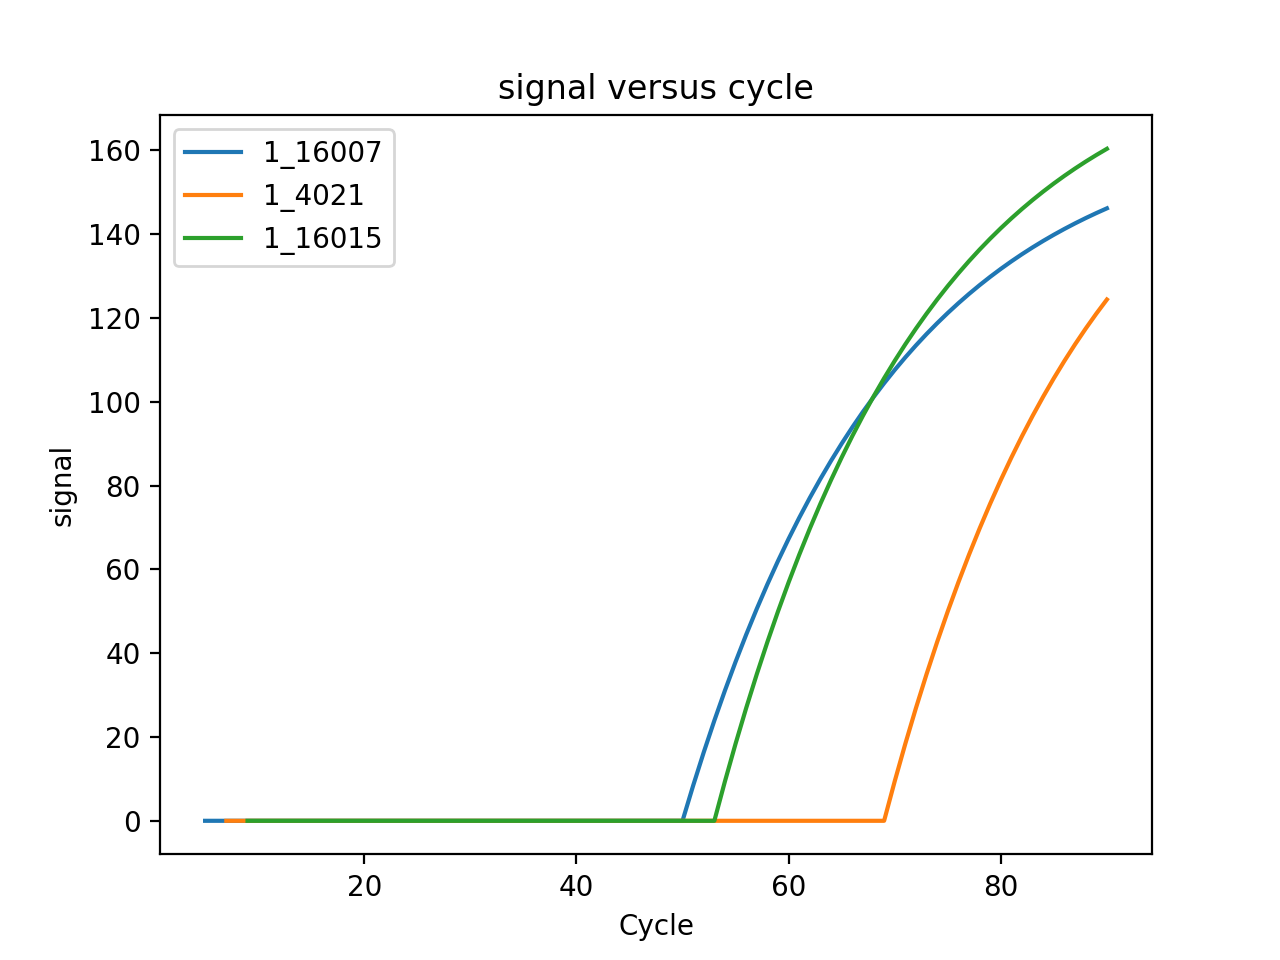

In [12]:
%matplotlib notebook

nds_plot_data("output/store_signal.db","signal",select=[DataID(1,16007),DataID(1,4021),DataID(1,16015)])